#<font color='green' size=5> **Масштабирование признаков**

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, LogisticRegression
from sklearn.metrics import (mean_absolute_error, root_mean_squared_error, r2_score, roc_auc_score)


import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)


#<font color='green' size=5> **Загрузка данных и определение ролей переменных**

In [10]:
try:
  data = fetch_california_housing(as_frame=True)
  df = data.frame
  target = 'MedHouseVal'
except Exception as e:
  print(e)
  !gdown 1ndW2qOmF_YIgJhJ4ZyrmFwtRkOLGp5zL
  df = pd.read_csv('/content/housing.csv')
  target = 'median_house_value'

In [11]:
# названия столбцов приведем к lowecase
df.columns=[col.lower() for col in df.columns]
target = target.lower()

In [12]:
df.head()

,medinc,houseage,averooms,avebedrms,population,aveoccup,latitude,longitude,medhouseval
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [13]:
df.columns

Index(['medinc', 'houseage', 'averooms', 'avebedrms', 'population', 'aveoccup',
       'latitude', 'longitude', 'medhouseval'],
      dtype='object')

In [14]:
# зададим роли переменным
ids = ['latitude', 'longitude']
target = 'medhouseval'
features_num = [col for col in df.select_dtypes(include='number').columns if col not in ids + [target, ]]
features_cat = [col for col in df.select_dtypes(exclude='number').columns if col not in ids + [target, ]]
features_num, features_cat

(['medinc', 'houseage', 'averooms', 'avebedrms', 'population', 'aveoccup'], [])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   medinc       20640 non-null  float64
 1   houseage     20640 non-null  float64
 2   averooms     20640 non-null  float64
 3   avebedrms    20640 non-null  float64
 4   population   20640 non-null  float64
 5   aveoccup     20640 non-null  float64
 6   latitude     20640 non-null  float64
 7   longitude    20640 non-null  float64
 8   medhouseval  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [16]:
shape_orig = df.shape[0]

# <font color='green' size=5>**EDA**

##<font color='blue' size=4> анализ целевого признака

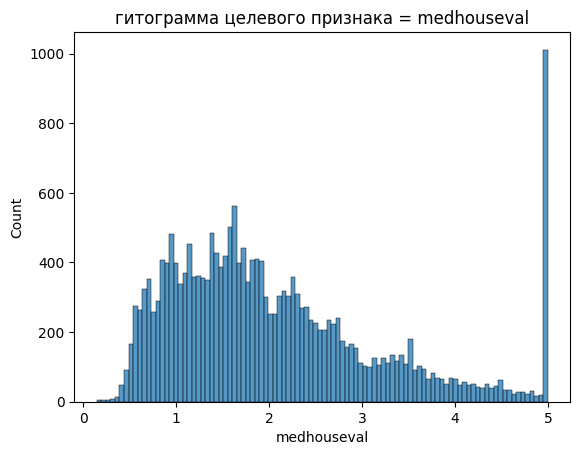

In [10]:
sns.histplot(df[target], bins=100)
plt.title(f'гитограмма целевого признака = {target}')
plt.show()

In [11]:
df[target].describe()

,medhouseval
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


In [18]:
# Преобразование таргета, создадим переменную индикатор: выброс или нет
IQR = df[target].quantile(0.75) - df[target].quantile(0.25)
lower = df[target].quantile(0.25) - 1.5 * IQR
upper = df[target].quantile(0.75) + 1.5 * IQR
df['is_high_price'] = np.where((df[target] >= lower) & (df[target] <= upper), 0, 1)

In [19]:
df.sort_values('is_high_price')

,medinc,houseage,averooms,avebedrms,population,aveoccup,latitude,longitude,medhouseval,is_high_price
13521,5.2072,20.0,6.170213,0.962766,543.0,2.888298,34.24,-117.41,1.64300,0
13530,5.5136,19.0,6.629921,1.000000,1176.0,3.086614,34.18,-117.30,1.37100,0
13529,3.6362,6.0,4.871773,1.107573,2943.0,2.532702,34.17,-117.32,1.06500,0
13528,3.0078,25.0,4.912127,1.047452,1650.0,2.899824,34.17,-117.31,0.87100,0
13527,1.8750,30.0,5.668950,1.308219,1172.0,2.675799,34.17,-117.30,0.89700,0
...,...,...,...,...,...,...,...,...,...,...
17047,7.4678,15.0,6.594465,1.073406,2009.0,2.417569,37.48,-122.29,5.00001,1
17045,8.5184,26.0,6.759542,0.967557,1392.0,2.656489,37.48,-122.27,5.00001,1
17043,6.5475,25.0,6.992374,1.102955,2626.0,2.503337,37.49,-122.28,5.00001,1
4360,2.8942,31.0,3.914369,1.024673,1059.0,1.537010,34.09,-118.37,5.00001,1


In [14]:
df['is_high_price'].sum()

np.int64(1071)

In [15]:
print(f"всего {df['is_high_price'].sum()} выбросов, что составляет {round(df['is_high_price'].sum()/shape_orig*100, 2)}%")

всего 1071 выбросов, что составляет 5.19%


In [17]:
bin_target = 'is_high_price'

In [17]:
# df = df[(df[target] >= lower) & (df[target] <= upper)]

##<font color='blue' size=4> анализ непрерывных переменных

In [18]:
features_num

['medinc', 'houseage', 'averooms', 'avebedrms', 'population', 'aveoccup']

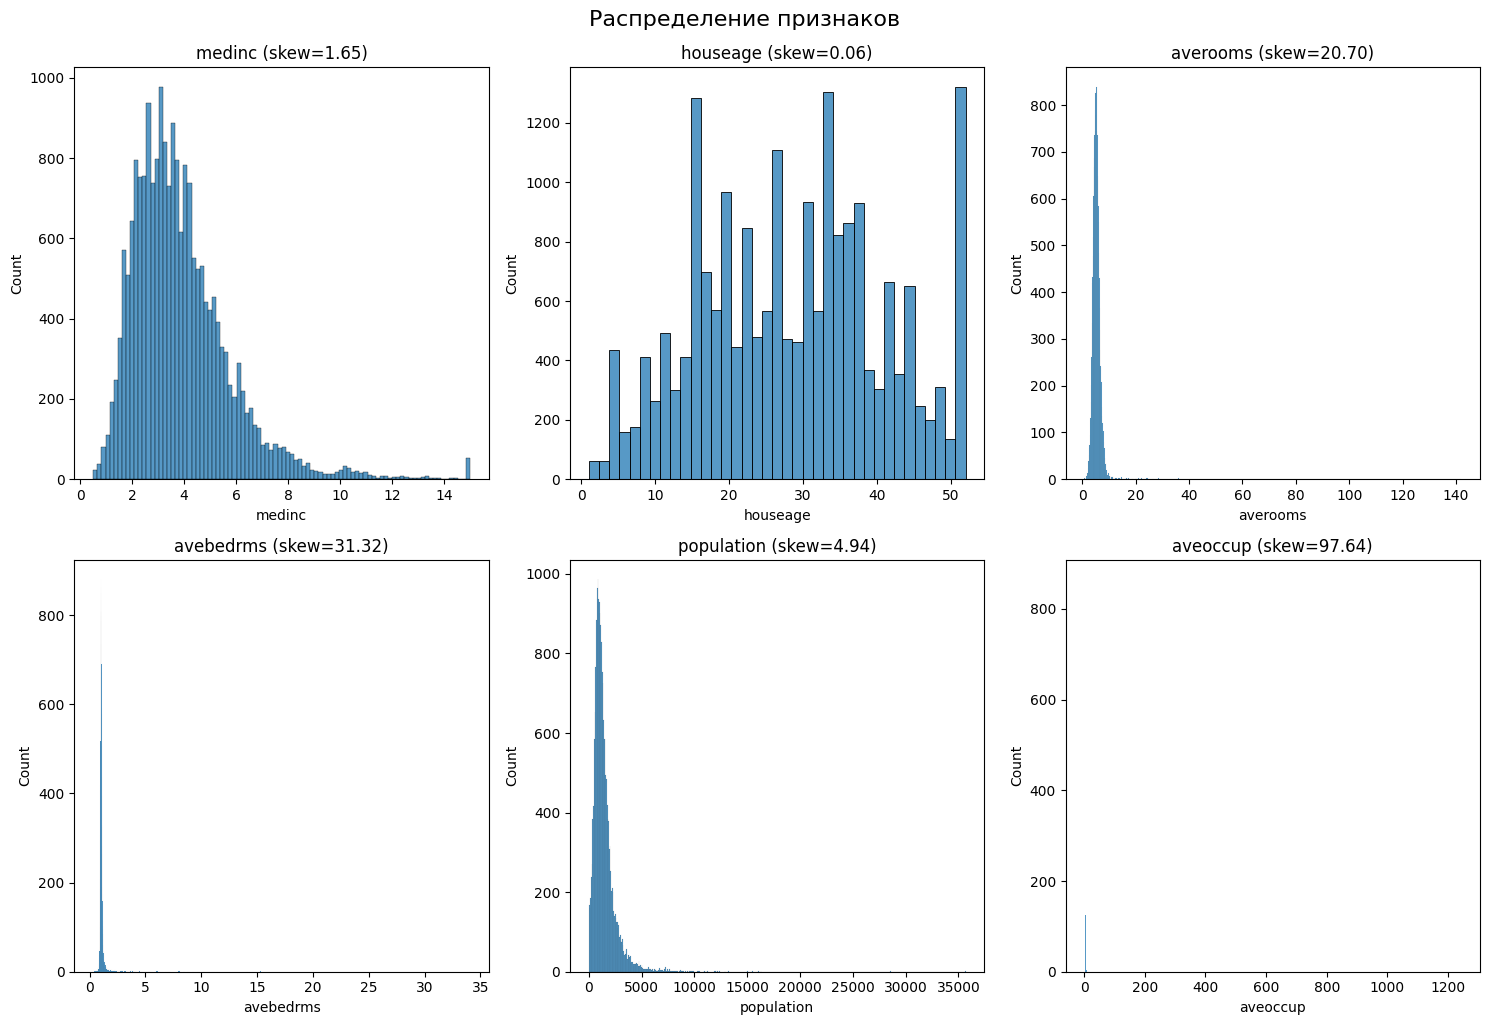

In [19]:
# Посмотрим на распределения
plt.figure(figsize=(15, 10))
n_cols = len(features_num) // 3
n_rows = 3 if len(features_num) % 3 == 0 else 4
for i, col in enumerate(features_num):
    plt.subplot(n_cols, n_rows, i + 1)
    sns.histplot(df[col], kde=False)
    plt.title(f'{col} (skew={df[col].skew():.2f})')
plt.tight_layout()
plt.suptitle("Распределение признаков", fontsize=16, y=1.02)
plt.show()


In [20]:
# создадим новую переменную
df['avebedrms_averooms'] = df['avebedrms'] /df['averooms']
features_num.append('avebedrms_averooms')

In [21]:
print("Описательная статистика:")
display(df[features_num].describe().T)


Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
medinc,20640.000000,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
houseage,20640.000000,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
averooms,20640.000000,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
avebedrms,20640.000000,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
population,20640.000000,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
aveoccup,20640.000000,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
avebedrms_averooms,20640.000000,0.213075,0.058023,0.100000,0.175426,0.203181,0.239834,1.000000


# <font color='green' size=5>**Разделим выборку на трейн и тест**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[features_num],
                                                    df[[target, bin_target]],
                                                    # stratify = df[bin_target],
                                                    test_size=0.2, random_state=42)


In [22]:
y_train[bin_target].mean(), y_test[bin_target].mean()

(np.float64(0.052749515503875966), np.float64(0.04844961240310078))

In [23]:
y_train_bin, y_test_bin = y_train[bin_target], y_test[bin_target]

In [30]:
y_train_bin.mean(), y_test_bin.mean()

(np.float64(0.052749515503875966), np.float64(0.04844961240310078))

In [24]:
y_train, y_test = y_train[target], y_test[target]

# <font color='green' size=5>**Моделирование**

##<font size=4>**Точно ли нужна нормализация?**

In [25]:
# Линейная регрессия без скейлера
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_orig = lr.predict(X_test)
mae_orig = mean_absolute_error(y_test, y_pred_orig)
rmse_orig = root_mean_squared_error(y_test, y_pred_orig)

res_without_scaler = {
    "Scaler": "None",
    "MAE": mae_orig,
    "RMSE":rmse_orig
}
res_without_scaler


{'Scaler': 'None', 'MAE': 0.5695346842257899, 'RMSE': 0.784416322678881}

<font color='red'>StandardScaler (как и любой препроцессинг, зависящий от данных) должен быть обучен только на тренировочной выборке, иначе можно получить утечку данных (data leakage).

Почему это важно?

- это искусственно улучшает результаты и делает модель нереалистично оптимистичной;

- при развёртывании в проде скейлер не будет знать статистику новых данных — и всё начнёт работать иначе.

In [26]:
# нормализация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Линейная регрессия со StandardScaler

lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_scaled)
rmse = root_mean_squared_error(y_test, y_pred_scaled)

res_wit_scaler = {
    "Scaler": "StandardScaler",
    "MAE": mae,
    "RMSE":rmse
}
res_wit_scaler



{'Scaler': 'StandardScaler',
 'MAE': 0.5695346842257903,
 'RMSE': 0.7844163226788807}

y = w_0 + w_1*x_1 + w_2*x_2+...w_n*x_n

In [29]:
X_train

,medinc,houseage,averooms,avebedrms,population,aveoccup,avebedrms_averooms
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,0.200576
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,0.232703
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,0.174486
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,0.258269
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,0.180940
...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,0.926267,658.0,3.032258,0.151128
11964,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,0.184825
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,0.270823
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,0.166993


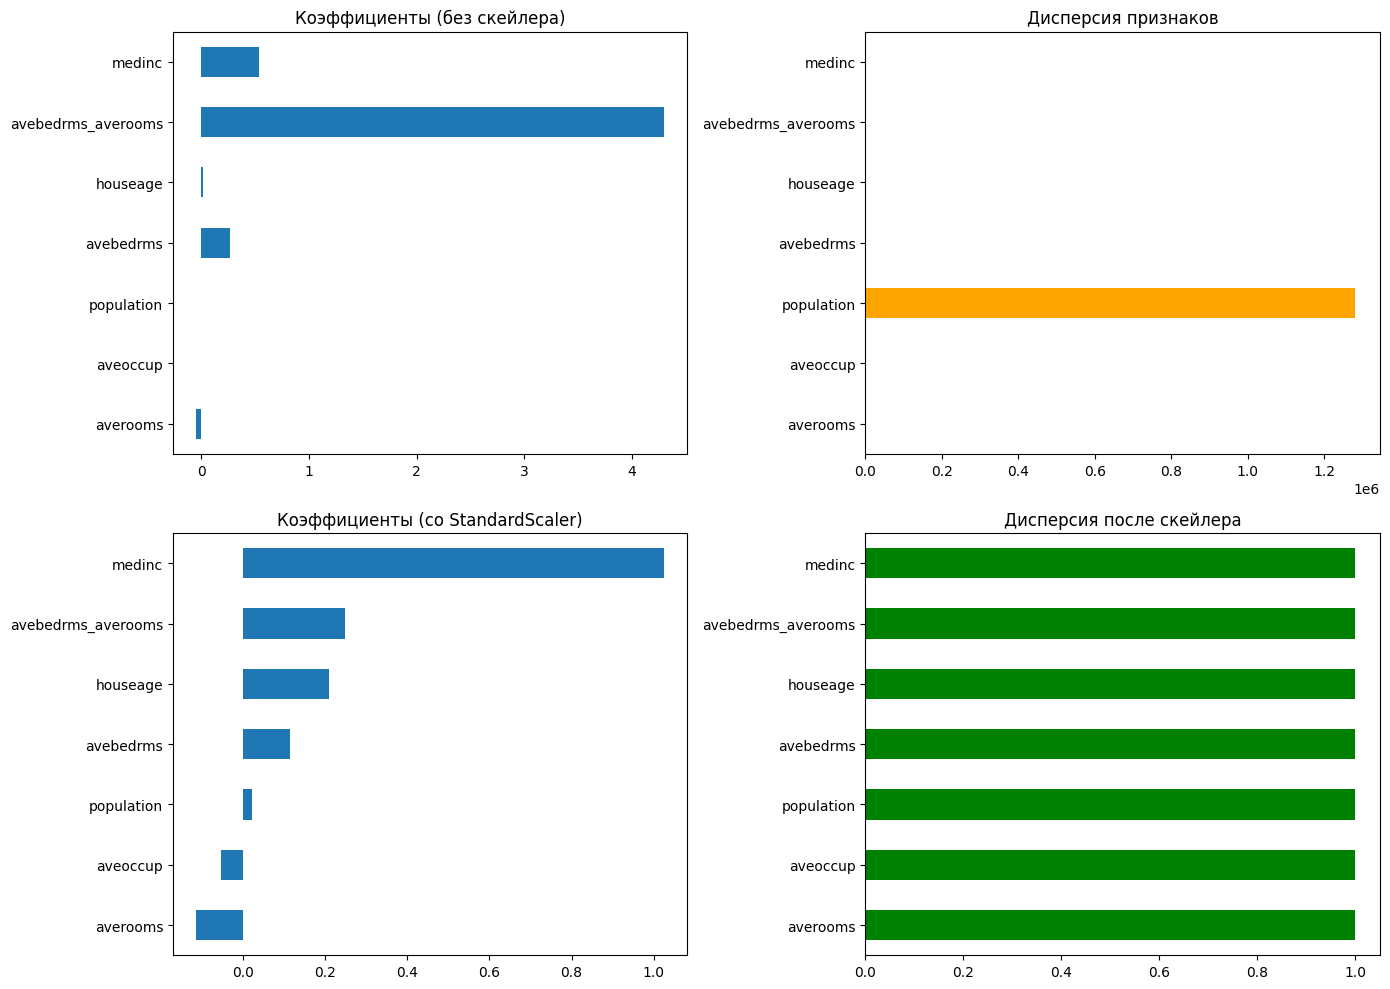

,Без скейлера,Со скейлером
averooms,0.047556,0.113530
aveoccup,0.004659,0.053947
population,0.000019,0.022010
avebedrms,0.264736,0.114684
houseage,0.016668,0.210053
avebedrms_averooms,4.300926,0.249426
medinc,0.538518,1.025466


In [28]:
# Сохраним коэфы
coef_raw = pd.Series(lr.coef_, index=features_num)
coef_scaled = pd.Series(lr_scaled.coef_, index=features_num)

# Посчитаем дисперсии
feature_variances = df[features_num].var()

# Получим сортировку по важности (по модулю коэффициента после скейлера)
sorted_features = coef_scaled.sort_values(ascending=True).index

# Отсортируем всё по этому порядку
coef_raw = coef_raw.loc[sorted_features]
coef_scaled = coef_scaled.loc[sorted_features]
feature_variances = feature_variances.loc[sorted_features]

# Построим сравнение
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Коэффициенты без скейлера
coef_raw.plot(kind='barh', ax=axes[0, 0], title='Коэффициенты (без скейлера)')

# Дисперсия без скейлера
feature_variances.plot(kind='barh', ax=axes[0, 1], color='orange', title='Дисперсия признаков')

# Коэффициенты со скейлером
coef_scaled.plot(kind='barh', ax=axes[1, 0], title='Коэффициенты (со StandardScaler)')

# Дисперсия после скейлера (≈1)
pd.Series(1.0, index=sorted_features).plot(kind='barh', ax=axes[1, 1], color='green', title='Дисперсия после скейлера')

plt.tight_layout()
plt.show()

# Сравним по модулю, кто важнее
importance_comparison = pd.DataFrame({
    'Без скейлера': coef_raw.abs(),
    'Со скейлером': coef_scaled.abs()
})

importance_comparison.head(10)


<font color='green' size=4>StandardScaler нужен для того, чтобы признаки имели одинаковый масштаб, чтобы модель могла корректно интерпретировать значимость признаков.

In [30]:
# Линейная регрессия без скейлера, обучение - градиентный спуск
lr = SGDRegressor(max_iter=20000, tol=1e-4, random_state=42, alpha=0, l1_ratio=0)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

y_pred_orig = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_orig)
rmse = root_mean_squared_error(y_test, y_pred_orig)

res_without_scaler = {
    "Scaler": "None",
    "MAE": mae,
    "RMSE":rmse
}
res_without_scaler


{'Scaler': 'None', 'MAE': 611508181356936.5, 'RMSE': 777251035409632.4}

In [31]:
# Линейная регрессия со StandardScaler, обучение - градиентный спуск

lr_scaled = SGDRegressor(max_iter=20000, tol=1e-4, random_state=42, alpha=0, l1_ratio=0)
lr_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_scaled)
rmse = root_mean_squared_error(y_test, y_pred_scaled)

res_with_scaler = {
    "Scaler": "StandardScaler",
    "MAE": mae,
    "RMSE":rmse
}
res_with_scaler



{'Scaler': 'StandardScaler',
 'MAE': 0.5689010347992915,
 'RMSE': 0.7806005739356693}

<font color='green' size=4>StandardScaler нужен для того, чтобы сходился градиентый спуск

In [32]:
# Модель без масштабирования
lasso_raw = Lasso(alpha=0.001)
lasso_raw.fit(X_train, y_train)
coef_lasso_raw = pd.Series(lasso_raw.coef_, index=features_num)
coef_lasso_raw.sort_values(ascending=False)

,0
avebedrms_averooms,3.231681
medinc,0.536193
avebedrms,0.433899
houseage,0.016726
population,0.000020
aveoccup,-0.004630
averooms,-0.083638


In [33]:
#Модель с масштабированием
lasso_scaled = Lasso(alpha=0.001)
lasso_scaled.fit(X_train_scaled, y_train)
coef_lasso_scaled = pd.Series(lasso_scaled.coef_, index=features_num)
coef_lasso_scaled.sort_values(ascending=False)

,0
medinc,1.017733
avebedrms_averooms,0.259324
houseage,0.208864
avebedrms,0.085944
population,0.020537
aveoccup,-0.052708
averooms,-0.081976


<font color='green' size=4>
- Регуляризация без стандартизации работает "нечестно" — важные признаки могут быть выкинуты, если у них просто маленький масштаб.

##<font size=4>**Какой метод нормализации выбрать?**

### 1. StandardScaler

**Что делает:**  
Масштабирует данные так, чтобы **среднее = 0**, а **стандартное отклонение = 1**.

**Формула:**  
$
z = \frac{x - \mu}{\sigma}
$
где $ \mu $ — среднее значение признака,  
а $ \sigma $ — стандартное отклонение.

**Когда использовать:**
- Когда данные имеют распределение, близкое к **нормальному (Gaussian)**.
- Когда важны отклонения от среднего (например, для линейной или логистической регрессии, PCA).

**Уязвим к выбросам:** ✅ Да

---

### 2. RobustScaler

**Что делает:**  
Использует **медиану** и **интерквартильный размах (IQR)** вместо среднего и стандартного отклонения.

**Формула:**  
$
x_{\text{scaled}} = \frac{x - \text{median}}{\text{IQR}}
$
где  
$
\text{IQR} = Q3 - Q1
$

**Когда использовать:**
- Когда в данных есть **выбросы**.
- Когда данные асимметричны.

**Уязвим к выбросам:** ❌ Нет

---

### 3. MinMaxScaler

**Что делает:**  
Масштабирует данные в диапазон от 0 до 1.

**Формула:**  
$
x_{\text{scaled}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$

**Когда использовать:**
- Когда признаки должны быть в **одном масштабе** (например, для k-NN, нейросетей).
- Когда нет сильных выбросов.

**Уязвим к выбросам:** ✅ Да

---

### 🔍 Сравнение

| Характеристика       | StandardScaler         | RobustScaler           | MinMaxScaler         |
|----------------------|------------------------|-------------------------|----------------------|
| Центрирование        | По среднему            | По медиане              | Нет                  |
| Масштаб              | По стандартному откл.  | По интерквартильному    | В диапазон \([0, 1]\) |
| Устойчив к выбросам  | ❌ Нет                  | ✅ Да                   | ❌ Нет               |
| Подходит для         | Нормальных данных      | Данных с выбросами      | Данных без выбросов  |
| Часто используется в | PCA, лин. модели       | Робастные модели        | k-NN, нейросети      |


In [34]:
scalers = {
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "MinMaxScaler": MinMaxScaler()
}

In [35]:
results = []

for scaler_name, scaler in scalers.items():
    # Масштабирование
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SGDRegressor(max_iter=20000, tol=1e-4, random_state=42, alpha=0, l1_ratio=0)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    results.append({
        "Scaler": scaler_name,
        "MAE": mae,
        "RMSE":rmse
    })

In [36]:
results

[{'Scaler': 'StandardScaler',
  'MAE': 0.5689010347992915,
  'RMSE': 0.7806005739356693},
 {'Scaler': 'RobustScaler',
  'MAE': 61716652533.44634,
  'RMSE': 179330518762.51175},
 {'Scaler': 'MinMaxScaler',
  'MAE': 0.5764728048359544,
  'RMSE': 0.7869006112689975}]

In [37]:
results_df = pd.DataFrame(results).sort_values(by=['MAE'], ascending=[False])
print("\n Сравнение моделей:")
display(results_df)


 Сравнение моделей:


,Scaler,MAE,RMSE
1,RobustScaler,61716652533.446342,179330518762.511749
2,MinMaxScaler,0.576473,0.786901
0,StandardScaler,0.568901,0.780601


##<font size=4>**Улучшение модели**

1) классификация: 1- высокая стоимость, 0 - низкая стоимость  
2) регрессия отдельно для низкой стоимость - regr_1.  
3) регрессия для высокой стоимости - regr_2.  
4) финальный прогноз = если прогноз 1 модели (вероятность 1) > treshold  то regr_2 иначе regr_1

In [38]:
# Выбираем индексы, где bin_target == 0
mask_train_low = y_train_bin == 0

X_train_low = X_train.loc[mask_train_low]
y_train_low = y_train.loc[mask_train_low]


mask_test_low = y_test_bin == 0

X_test_low = X_test.loc[mask_test_low]
y_test_low = y_test.loc[mask_test_low]


In [39]:
# Выбираем индексы, где bin_target == 1
mask_train_high = y_train_bin == 1

X_train_high = X_train.loc[mask_train_high]
y_train_high = y_train.loc[mask_train_high]


mask_test_high = y_test_bin == 1

X_test_high = X_test.loc[mask_test_high]
y_test_high = y_test.loc[mask_test_high]


In [55]:
clf = LogisticRegression(penalty='l1', C = 1, solver='liblinear', random_state=42)
clf.fit(X_train_scaled, y_train_bin)

y_pred_train = clf.predict_proba(X_train_scaled)[:,1]
y_pred_test = clf.predict_proba(X_test_scaled)[:,1]
y_pred_test

array([0.00155406, 0.00511671, 0.10799238, ..., 0.57103372, 0.00551991,
       0.00773981])

In [56]:
roc_auc = roc_auc_score(y_test_bin, y_pred_test)
print(f"ROC AUC TEST: {roc_auc_score(y_test_bin, y_pred_test):.4f} \nROC AUC TRAIN: {roc_auc_score(y_train_bin, y_pred_train):.4f}")

ROC AUC TEST: 0.8922 
ROC AUC TRAIN: 0.9181


In [57]:

# === Регрессия: обычные значения (is_high_price == 0) ===

scaler_low = StandardScaler()
X_train_low_scaled = scaler_low.fit_transform(X_train_low)
X_test_low_scaled = scaler_low.transform(X_test_low)

reg_low = Lasso(alpha=0.02)
reg_low.fit(X_train_low_scaled, y_train_low)
y_pred_low = reg_low.predict(X_test_low_scaled)

print("\n=== Regression for Normal Prices ===")
print("RMSE:", root_mean_squared_error(y_test_low, y_pred_low))



=== Regression for Normal Prices ===
MSE: 0.6758597317924367


In [58]:
# === Регрессия или среднее: выбросы (is_high_price == 1) ===
N = 300
if len(X_train_high) > N:

    scaler_high = StandardScaler()
    X_train_high_scaled = scaler_high.fit_transform(X_train_high)
    X_test_high_scaled = scaler_high.transform(X_test_high)

    reg_high = Lasso(alpha=10)
    reg_high.fit(X_train_high_scaled, y_train_high)
    y_pred_high = reg_high.predict(X_test_high_scaled)

    print("\n=== Regression (Ridge) for High Prices ===")
    print("RMSE:", root_mean_squared_error(y_test_high, y_pred_high))
else:
    mean_high = y_train_high.mean()
    print(f"\n=== High Prices: too few rows ({len(X_train_high)}), using mean prediction ===")
    print(f"Mean value prediction: {mean_high:.2f}")



=== Regression (Ridge) for High Prices ===
RMSE: 0.03529877152051453


<Axes: ylabel='Count'>

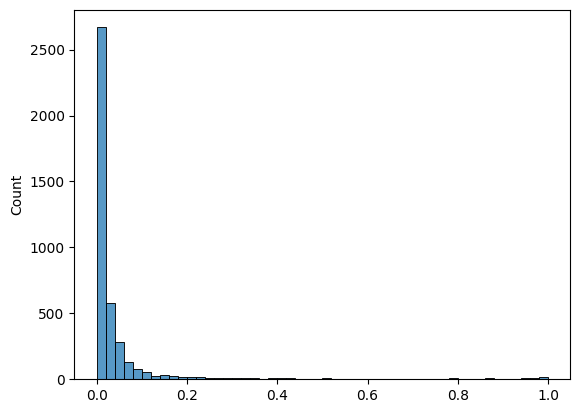

In [59]:
sns.histplot(clf.predict_proba(X_test_scaled)[:,1], bins=50)

In [60]:
proba_high = clf.predict_proba(X_test_scaled)[:, 1]

# Предсказания обеих моделей
pred_low = reg_low.predict(scaler_low.transform(X_test))
pred_high = reg_high.predict(scaler_high.transform(X_test))

# Выбираем, где вероятность < 0.5, там pred_low, иначе pred_high
y_pred_test = np.where(proba_high < 0.5, pred_low, pred_high)


In [61]:
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("RMSE:", root_mean_squared_error(y_test, y_pred_test))

MAE: 0.5529335674959623
RMSE: 0.7793501154608125
